(pre-processing:feature-selection)=
# Feature selection
``````{dropdown} <i class="fa-solid fa-gear"></i>   Environment setup
`````{tab-set}

````{tab-item} Steps
```{include} ../_static/default_text_env_setup.md
```
````

````{tab-item} yml
```{literalinclude} preprocessing_visualization.yml
:language: yaml
```
````

`````
``````
<!-- END DROPDOWNS -->


```{dropdown} <i class="fas fa-brain"></i>&nbsp;&nbsp;&nbsp;Key takeaways

:::{card}
:link: preprocessing-visualization-feature-selection-key-takeaway-1
:link-type: ref
Feature selection in single-cell RNA-seq data focuses on identifying the most informative genes by using methods like deviance, which avoids biases from arbitrary normalization choices.
:::

```


<!-- START ENV-SETUP -->
<!-- END ENV-SETUP -->

(preprocessing-visualization-feature-selection-key-takeaway-1)=
## Motivation

We now have a normalized data representation that still preserves biological heterogeneity but with reduced technical sampling effects in gene expression. Single-cell RNA-seq datasets usually contain up to 30,000 genes and so far we only removed genes that are not detected in at least 20 cells. However, many of the remaining genes are not informative and contain mostly zero counts. Therefore, a standard preprocessing pipeline involves the step of feature selection which aims to exclude uninformative genes which might not represent meaningful biological variation across samples. 

:::{figure-md} Feature selection

<img src="../_static/images/preprocessing_visualization/feature_selection.jpeg" alt="Feature selection" class="bg-primary mb-1" width="800px">

Feature selection generally describes the process of only selecting a subset of relevant features which can be the most informative, most variable or most deviant ones. 

:::


Usually, the scRNA-seq experiment and resulting dataset focuses on one specific tissue and hence, only a small fraction of genes is informative and biologically variable. Traditional approaches and pipelines either compute the coefficient of variation (highly variable genes) or the average expression level (highly expressed genes) of all genes to obtain 500-2000 selected genes and use these features for their downstream analysis steps. However, these methods are highly sensitive to the normalization technique used before. As mentioned earlier, a former preprocessing workflow included normalization with CPM and subsequent log transformation. But as log-transformation is not possible for exact zeros, analysts often add a small *pseudo count*, e.g., 1 (log1p), to all normalized counts before log transforming the data. Choosing the pseudo count, however, is arbitrary and can introduce biases to the transformed data. This arbitrariness has then also an effect on the feature selection as the observed variability depends on the chosen pseudo count. A small pseudo count value close to zero is increasing the variance of genes with zero counts {cite}`Townes2019`. 

Germain et al. instead proposes to use *deviance* for feature selection which works on raw counts {cite}`fs:germain_pipecomp_2020`. Deviance can be computed in closed form and quantifies whether genes show a constant expression profile across cells as these are not informative. Genes with constant expression are described by a multinomial null model, they are approximated by the binomial deviance. Highly informative genes across cells will have a high deviance value which indicates a poor fit by the null model (i.e., they don't show constant expression across cells). According to the deviance values, the method then ranks all genes and obtains only highly deviant genes. 

As mentioned before, deviance can be computed in closed form and is provided within the R package scry.

We start by setting up our environment.

In [1]:
import logging

import anndata2ri
import matplotlib.pyplot as plt
import numpy as np
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
import scanpy as sc
import seaborn as sns

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
%%R
library(scry)

Next, we load the already normalized dataset. Deviance works on raw counts so there is no need to replace `adata.X` with one of the normalized layers, but we can directly use the object as it was stored in the normalization notebook. 

In [3]:
adata = sc.read(
    filename="s4d8_normalization.h5ad",
    backup_url="https://figshare.com/ndownloader/files/40015741",
)

Similar to before, we save the AnnData object in our R environment. 

In [4]:
ro.globalenv["adata"] = adata

We can now directly call feature selection with deviance on the non-normalized counts matrix and export the binomial deviance values as a vector. 

In [5]:
%%R
sce = devianceFeatureSelection(adata, assay="X")

In [6]:
binomial_deviance = ro.r("rowData(sce)$binomial_deviance").T

As a next step, we now sort the vector and select the top 4,000 highly deviant genes and save them as an additional column in `.var` as 'highly_deviant'. We additionally save the computed binomial deviance in case we want to sub-select a different number of highly variable genes afterwards. 

In [7]:
idx = binomial_deviance.argsort()[-4000:]
mask = np.zeros(adata.var_names.shape, dtype=bool)
mask[idx] = True

adata.var["highly_deviant"] = mask
adata.var["binomial_deviance"] = binomial_deviance

Last, we visualise the feature selection results. We use a scanpy function to compute the mean and dispersion for each gene across all cells.

In [8]:
sc.pp.highly_variable_genes(adata, layer="scran_normalization")

We inspect our results by plotting dispersion versus mean for the genes and color by 'highly_deviant'.

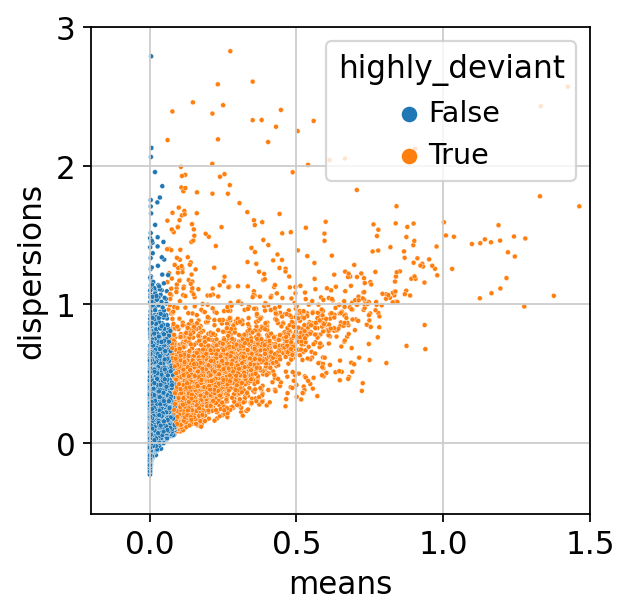

In [9]:
ax = sns.scatterplot(
    data=adata.var, x="means", y="dispersions", hue="highly_deviant", s=5
)
ax.set_xlim(None, 1.5)
ax.set_ylim(None, 3)
plt.show()

We observe that genes with a high mean expression are selected as highly deviant. This is in agreement with empirical observations by {cite}`Townes2019`.

In [10]:
adata.write("s4d8_feature_selection.h5ad")

## References

```{bibliography}
:filter: docname in docnames
:labelprefix: fs
```

## Contributors

We gratefully acknowledge the contributions of:

### Authors

* Anna Schaar

### Reviewers

* Lukas Heumos
